In [ ]:
provider = IBMQ.load_account()

In [100]:
%matplotlib notebook

In [74]:
#from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, IBMQ, transpile 
import qiskit
import math
import random
import numpy as np
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML


# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error, amplitude_damping_error

In [75]:
# Build noise circuit 

n_qubits = 1
noise_circ = QuantumCircuit(n_qubits)
noise_circ.h(0)
noise_circ.u(math.pi/3, 0, math.pi/6, 0)
noise_circ.x(0)
noise_circ.save_density_matrix(label = f'density')
noise_circ.measure_all()
print(noise_circ)

        ┌───┐┌──────────────┐┌───┐ ░  ░ ┌─┐
     q: ┤ H ├┤ U(π/3,0,π/6) ├┤ X ├─░──░─┤M├
        └───┘└──────────────┘└───┘ ░  ░ └╥┘
meas: 1/═════════════════════════════════╩═
                                         0 


In [76]:
# Building noise models 

## Bit-flip error - on measurement 
p_bitflip_1 = 0.1
p_bitflip_2 = 0.5
p_bitflip_3 = 0.9
error_bitflip_1 = pauli_error([('X',p_bitflip_1), ('I', 1 - p_bitflip_1)])
error_bitflip_2 = pauli_error([('X',p_bitflip_2), ('I', 1 - p_bitflip_2)])
error_bitflip_3 = pauli_error([('X',p_bitflip_3), ('I', 1 - p_bitflip_3)])
noise_bitflip_1 = NoiseModel()
noise_bitflip_2 = NoiseModel()
noise_bitflip_3 = NoiseModel()
noise_bitflip_1.add_all_qubit_quantum_error(error_bitflip_1, ['u'])
noise_bitflip_2.add_all_qubit_quantum_error(error_bitflip_2, ['u'])
noise_bitflip_3.add_all_qubit_quantum_error(error_bitflip_3, ['u'])

## Phase-flip error 
p_phaseflip_1 = 0.1
p_phaseflip_2 = 0.5
p_phaseflip_3 = 0.9
error_phaseflip_1 = pauli_error([('Z',p_phaseflip_1), ('I', 1 - p_phaseflip_1)])
error_phaseflip_2 = pauli_error([('Z',p_phaseflip_2), ('I', 1 - p_phaseflip_2)])
error_phaseflip_3 = pauli_error([('Z',p_phaseflip_3), ('I', 1 - p_phaseflip_3)])
noise_phaseflip_1 = NoiseModel()
noise_phaseflip_2 = NoiseModel()
noise_phaseflip_3 = NoiseModel()
noise_phaseflip_1.add_all_qubit_quantum_error(error_phaseflip_1, ['u'])
noise_phaseflip_2.add_all_qubit_quantum_error(error_phaseflip_2, ['u'])
noise_phaseflip_3.add_all_qubit_quantum_error(error_phaseflip_3, ['u'])

## Depolarizing error 
p_depolarizing_1 = 0.1
p_depolarizing_2 = 0.5
p_depolarizing_3 = 0.9
error_depolarizing_1 = depolarizing_error(p_depolarizing_1, 1)
error_depolarizing_2 = depolarizing_error(p_depolarizing_2, 1)
error_depolarizing_3 = depolarizing_error(p_depolarizing_3, 1)
noise_depolarizing_1 = NoiseModel()
noise_depolarizing_2 = NoiseModel()
noise_depolarizing_3 = NoiseModel()
noise_depolarizing_1.add_all_qubit_quantum_error(error_depolarizing_1, ['u'])
noise_depolarizing_2.add_all_qubit_quantum_error(error_depolarizing_2, ['u'])
noise_depolarizing_3.add_all_qubit_quantum_error(error_depolarizing_3, ['u'])

## Amplitude damping 
p_amp_damp_1 = 0.1
p_amp_damp_2 = 0.5
p_amp_damp_3 = 0.9
error_amp_damp_1 = amplitude_damping_error(p_amp_damp_1, 1)
error_amp_damp_2 = amplitude_damping_error(p_amp_damp_2, 1)
error_amp_damp_3 = amplitude_damping_error(p_amp_damp_3, 1)
noise_amp_damp_1 = NoiseModel()
noise_amp_damp_2 = NoiseModel()
noise_amp_damp_3 = NoiseModel()
noise_amp_damp_1.add_all_qubit_quantum_error(error_amp_damp_1, ['u'])
noise_amp_damp_2.add_all_qubit_quantum_error(error_amp_damp_2, ['u'])
noise_amp_damp_3.add_all_qubit_quantum_error(error_amp_damp_3, ['u'])

In [77]:
# Define simulators 
sim_ideal = AerSimulator()
sim_noise = AerSimulator(noise_model = noise_bitflip_3)



In [78]:
# Execute my ideal circuit
result_ideal = sim_ideal.run(noise_circ).result()


In [79]:
result_ideal = np.asarray(result_ideal.data()['density'])

In [80]:
result_ideal

array([[0.875     +0.j  , 0.21650635+0.25j],
       [0.21650635-0.25j, 0.125     +0.j  ]])

In [81]:
# Execute my noisy circuit
circ_tnoise = transpile(noise_circ, sim_noise)
result_bit_flip = sim_noise.run(circ_tnoise).result()

In [82]:
result_bit_flip

Result(backend_name='aer_simulator', backend_version='0.10.4', qobj_id='65b2003d-a0e6-4b96-879f-170d5d0a01ea', job_id='d9706601-1e12-4fd7-b709-58c964d82f75', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 201, '0x1': 823}, density=DensityMatrix([[0.2       +0.j , 0.21650635-0.2j],
               [0.21650635+0.2j, 0.8       +0.j ]],
              dims=(2,))), header=QobjExperimentHeader(clbit_labels=[['meas', 0]], creg_sizes=[['meas', 1]], global_phase=0.33347317225183204, memory_slots=1, metadata={}, n_qubits=1, name='circuit-385', qreg_sizes=[['q', 1]], qubit_labels=[['q', 0]]), status=DONE, seed_simulator=1437435361, metadata={'noise': 'superop', 'batched_shots_optimization': False, 'remapped_qubits': False, 'parallel_state_update': 4, 'parallel_shots': 1, 'device': 'CPU', 'active_input_qubits': [0], 'measure_sampling': True, 'num_clbits': 1, 'input_qubit_map': [[0, 0]], 'num_qubits': 1, 'method': 'density_matr

In [83]:
bit_flip_counts = result_bit_flip.get_counts()

In [84]:
bit_flip_counts

{'0': 201, '1': 823}

In [85]:
bit_flip_counts['0']/1024

0.1962890625

In [174]:
def noisy_circuit_model(integer, p):
    """ function which computes the probablity """
    if integer == 0:
        error_bitflip_1 = pauli_error([('X',p), ('I', 1 - p)])
        noise_bitflip_1 = NoiseModel()
        noise_bitflip_1.add_all_qubit_quantum_error(error_bitflip_1, ['u'])
        sim_noise = AerSimulator(noise_model = noise_bitflip_1)
    elif integer == 1:
        error_phaseflip_1 = pauli_error([('Z',p), ('I', 1 - p)])
        noise_phaseflip_1 = NoiseModel()
        noise_phaseflip_1.add_all_qubit_quantum_error(error_phaseflip_1, ['u'])
        sim_noise = AerSimulator(noise_model = noise_phaseflip_1)
    elif integer == 2:
        error_depolarizing_1 = depolarizing_error(p, 1)
        noise_depolarizing_1 = NoiseModel()
        noise_depolarizing_1.add_all_qubit_quantum_error(error_depolarizing_1, ['u'])
        sim_noise = AerSimulator(noise_model = noise_depolarizing_1)
    elif integer == 3:
        error_amp_damp_1 = amplitude_damping_error(p, 1)
        noise_amp_damp_1 = NoiseModel()
        noise_amp_damp_1.add_all_qubit_quantum_error(error_amp_damp_1, ['u'])
        sim_noise = AerSimulator(noise_model = noise_amp_damp_1)
    
    n_qubits = 1
    noise_circ = QuantumCircuit(n_qubits)
    noise_circ.h(0)
    noise_circ.u(math.pi/3, 0, math.pi/6, 0)
    noise_circ.x(0)
    noise_circ.save_density_matrix(label = 'density')
    noise_circ.measure_all()
  
    circ_tnoise = transpile(noise_circ, sim_noise)
    circ_ideal = transpile(noise_circ, sim_ideal)
    result_noise = sim_noise.run(circ_tnoise).result()
    result_ideal = sim_ideal.run(circ_ideal).result()
    density_ideal = np.asarray(result_ideal.data()['density'])
    density_noise = np.asarray(result_noise.data()['density'])

    a_ideal = density_ideal[0,0]
    b_ideal = density_ideal[1,0]
    x_ideal = 2.0*b_ideal.real
    y_ideal = 2.0*b_ideal.imag
    z_ideal = (2.0*a_ideal - 1.0).real
    
    a_noise = density_noise[0,0]
    b_noise = density_noise[1,0]
    x_noise = 2.0*b_noise.real
    y_noise = 2.0*b_noise.imag
    z_noise = (2.0*a_noise - 1.0).real
    
    length_noise = (x_noise**2 + y_noise**2 + z_noise**2)**(1/2)
    length_ideal = (x_ideal**2 + y_ideal**2 + z_ideal**2)**(1/2)

    counts_noise = result_noise.get_counts()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    r = 1
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = r * np.outer(np.cos(u), np.sin(v))
    y = r * np.outer(np.sin(u), np.sin(v))
    z = r * np.outer(np.ones(np.size(u)), np.cos(v))

    # Plot the surface
    ax.plot_surface(x, y, z, color='linen', alpha=0.25)

    # plot circular curves over the surface
    theta = np.linspace(0, 2 * np.pi, 100)
    z = np.zeros(100)
    x = r * np.sin(theta)
    y = r * np.cos(theta)

    ax.plot(x, y, z, color='black', alpha=0.5)
    ax.plot(z, x, y, color='black', alpha=0.5)

    ## add axis lines
    zeros = np.zeros(1000)
    line = np.linspace(-1.5,1.5,1000)

    ax.plot(line, zeros, zeros, color='black', alpha=0.75)
    ax.plot(zeros, line, zeros, color='black', alpha=0.75)
    ax.plot(zeros, zeros, line, color='black', alpha=0.75)

    numbers = [(0,0,0,x_ideal,y_ideal,z_ideal),(0,0,0,x_noise,y_noise,z_noise)]

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.set_axis_off()
    ax.text(-0.1,0,1.6,'|0>',fontsize='xx-large',fontweight = 'medium')
    ax.text(-0.1,0,-1.9,'|1>',fontsize='xx-large',fontweight = 'medium')
    ax.text(-1.6,-0.2,0,'x',fontsize='xx-large',fontweight = 'medium')
    ax.text(0.1,-1.95,0,'y',fontsize='xx-large',fontweight = 'medium')
    
    #ax.quiver(*numbers[0], normalize = True, color = 'red', lw = 4)
    
    def update(number):
        global quiver
        quiver.remove()
        quiver = ax.quiver(*numbers[number], normalize = True, color = 'red', lw =4)

    ani = FuncAnimation(fig, update, frames = [0,1], repeat = False, interval=200, blit=True)

    ani.save("./animation.gif", dpi=500, writer=PillowWriter(fps=2))
    
    
    #Outcome of playing the game - win/lose
    result_prob = random.choices([0,1],(counts_noise['0'],counts_noise['1']))
    
    
    #plot_bloch_multivector(result.data(0)['density']).savefig('./bloch_vector.png')
    plot_histogram(counts_noise).savefig('./histogram.png')
    
    return result_prob[0]
        

<IPython.core.display.Javascript object>


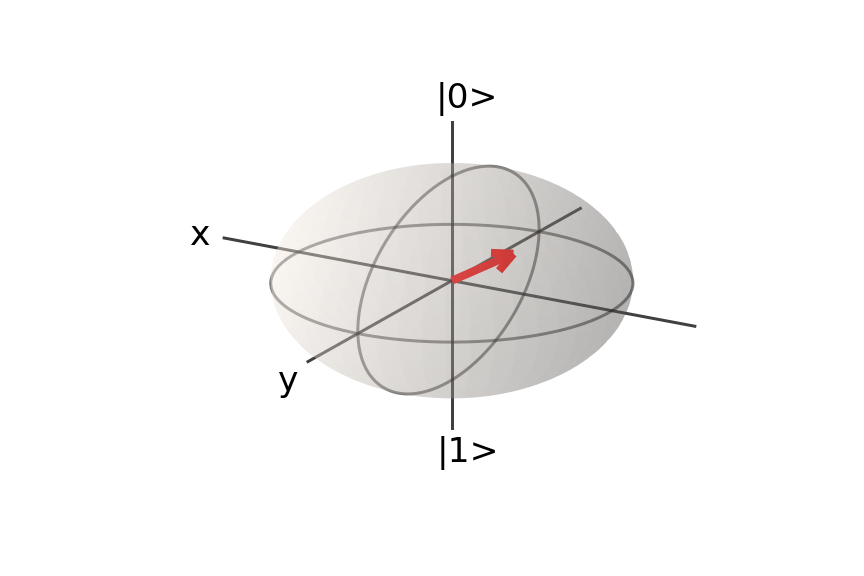

<IPython.core.display.Javascript object>


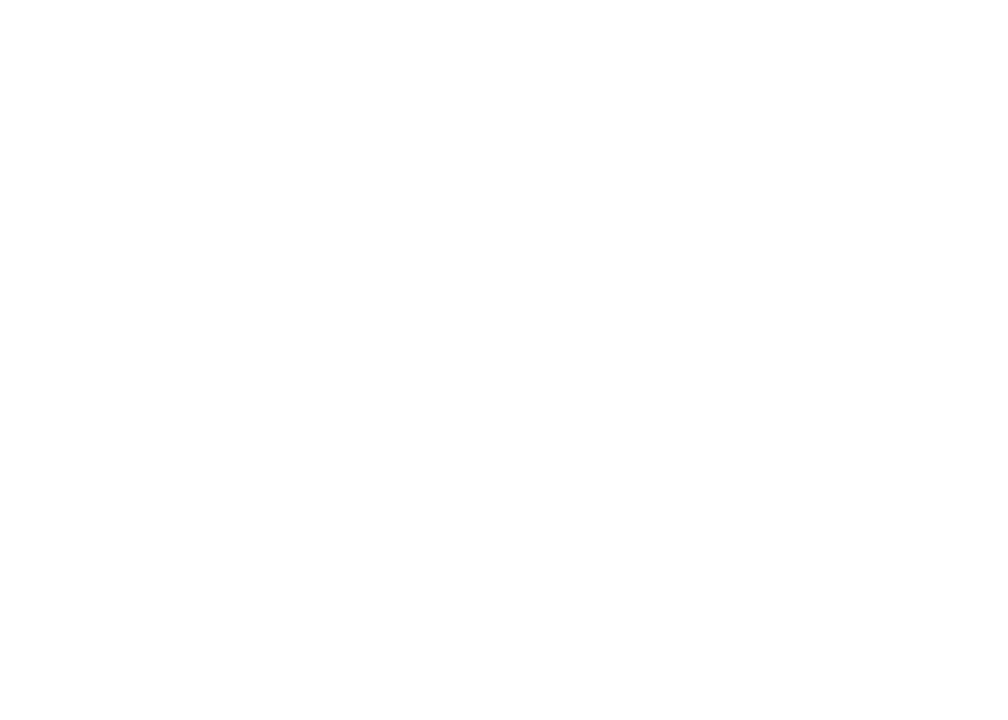

In [175]:
test = noisy_circuit_model(0,0.2)

<IPython.core.display.Javascript object>


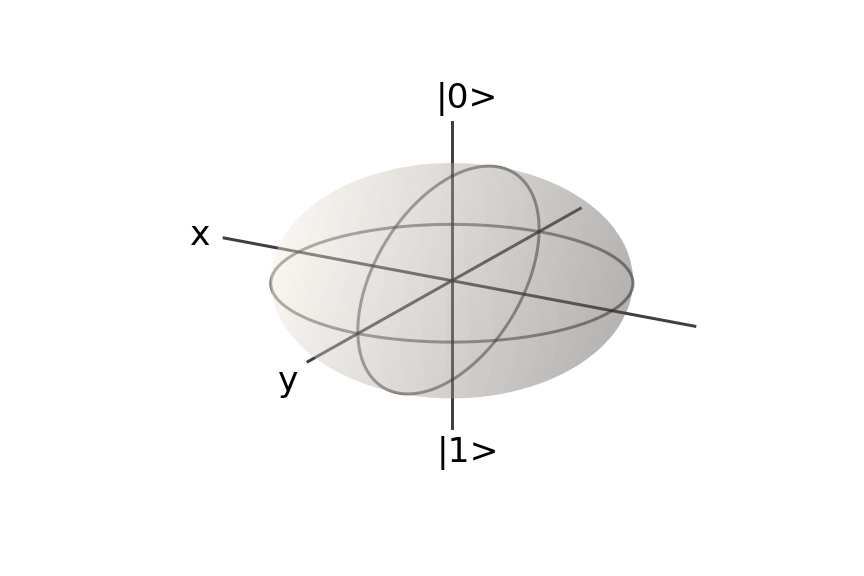

In [169]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

r = 1
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = r * np.outer(np.cos(u), np.sin(v))
y = r * np.outer(np.sin(u), np.sin(v))
z = r * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(x, y, z, color='linen', alpha=0.25)

# plot circular curves over the surface
theta = np.linspace(0, 2 * np.pi, 100)
z = np.zeros(100)
x = r * np.sin(theta)
y = r * np.cos(theta)

ax.plot(x, y, z, color='black', alpha=0.5)
ax.plot(z, x, y, color='black', alpha=0.5)

## add axis lines
zeros = np.zeros(1000)
line = np.linspace(-1.5,1.5,1000)

ax.plot(line, zeros, zeros, color='black', alpha=0.75)
ax.plot(zeros, line, zeros, color='black', alpha=0.75)
ax.plot(zeros, zeros, line, color='black', alpha=0.75)

numbers = [(0,0,0,0,0.5,0.5),(0,0,0,0,0,-1)]

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_axis_off()
ax.text(-0.1,0,1.6,'|0>',fontsize='xx-large',fontweight = 'medium')
ax.text(-0.1,0,-1.9,'|1>',fontsize='xx-large',fontweight = 'medium')
ax.text(-1.6,-0.2,0,'x',fontsize='xx-large',fontweight = 'medium')
ax.text(0.1,-1.95,0,'y',fontsize='xx-large',fontweight = 'medium')

def update(number):
    global quiver
    quiver.remove()
    quiver = ax.quiver(*numbers[number], normalize = False, color = 'red', lw =4)

ani = FuncAnimation(fig, update, frames = [0,1], repeat = False, interval=200, blit=True)

ani.save("./animation.gif", dpi=500, writer=PillowWriter(fps=2))